## 라이브러리 호출

In [2]:
import pandas as pd
import numpy as np
import math
import tqdm as tq


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

# 시계열 분석용 플롯 함수
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf  # 자기상관 함수 플롯
from statsmodels.graphics.tsaplots import plot_pacf  # 부분자기상관 함수 플롯
plt.style.use('fivethirtyeight')

# 모델링 및 예측
# ==============================================================================
from sklearn.linear_model import Ridge  # Ridge 회귀
from lightgbm import LGBMRegressor  # LightGBM 회귀
from sklearn.preprocessing import StandardScaler  # 표준화 스케일러
from sklearn.metrics import mean_absolute_error  # 평균 절대 오차
from sklearn.preprocessing import MinMaxScaler  # Min-Max 스케일러

# 추가 패키지
from xgboost import XGBRegressor  # XGBoost 회귀
import xgboost as xgb  # XGBoost 라이브러리
import lightgbm as lgb  # LightGBM 라이브러리
# import catboost as ctb  # CatBoost 라이브러리
from ngboost import NGBRegressor  # NGBoost 회귀

from sklearn.svm import SVR  # 서포트 벡터 회귀
from sklearn.ensemble import RandomForestRegressor  # 랜덤 포레스트 회귀
from sklearn.datasets import make_regression  # 회귀 데이터셋 생성
from sklearn.model_selection import GridSearchCV  # 하이퍼파라미터 그리드 서치
import math 

from sklearn.preprocessing import StandardScaler  # 표준화 스케일러
from sklearn.neural_network import MLPRegressor  # 다층 퍼셉트론 회귀
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 성능 평가 지표

from itertools import *  # 반복자와 조합 생성기
from IPython.display import clear_output  # 출력 지우기

In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 기호 깨짐 방지

## 데이터 불러오기

In [4]:
# 데이터 불러오기
train_data = pd.read_csv("./TRAIN_DATA_processed_category.csv")
train_data.head()

,AREA_ID,DIST_CD,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,FAC_TRAIN,FAC_SPORT,FAC_STAY,FAC_LEISURE,TOTAL_GAS,CMRC_GAS,TOTAL_ELEC,YEAR,MONTH
0,9626,27110,538.0,266.0,88.0,6.0,3.0,2.0,3.0,0.0,0.0,0.0,16.0,3.0,517520,466070,1174.570,2023,3
1,10350,47130,765.0,72.0,174.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,322681,318143,571.137,2023,3
2,9547,31200,343.0,74.0,161.0,1.0,3.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,921843,726861,1094.982,2022,12
3,9995,41360,129.0,4.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226095,223952,594.064,2023,12
4,9248,11740,34.0,2.0,14.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1884854,886279,2708.273,2023,1


In [5]:
# 데이터 불러오기
test_data = pd.read_csv("./TEST_DATA_processed_category.csv")
test_data.head()

,AREA_ID,DIST_CD,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,FAC_TRAIN,FAC_SPORT,FAC_STAY,FAC_LEISURE,TOTAL_GAS,CMRC_GAS,YEAR,MONTH
0,9180,11110,196,81,108,0,0,0,0,0,0,0,0,0,143394,143275,2023,3
1,10292,29140,17,1,1,0,0,0,0,0,0,0,0,0,3520,2315,2023,3
2,9323,11680,93,9,22,0,0,0,0,0,0,0,2,0,1548330,515034,2023,3
3,9884,41111,96,9,28,0,0,0,0,0,0,0,5,0,90053,89481,2023,7
4,9922,41220,381,6,20,0,1,1,0,0,0,0,0,2,196999,99915,2022,11


## 범주형 변환

In [6]:
# 범주형으로 변환
train_data["AREA_ID"] = train_data["AREA_ID"].astype("category")
train_data["DIST_CD"] = train_data["DIST_CD"].astype("category")
train_data["YEAR"] = train_data["YEAR"].astype("category")
train_data["MONTH"] = train_data["MONTH"].astype("category")

In [7]:
# 범주형으로 변환
test_data["AREA_ID"] = test_data["AREA_ID"].astype("category")
test_data["DIST_CD"] = test_data["DIST_CD"].astype("category")
test_data["YEAR"] = test_data["YEAR"].astype("category")
test_data["MONTH"] = test_data["MONTH"].astype("category")

## 데이터 시각화

📌 TOTAL_ELEC과 상관 높은 변수 순위:

TOTAL_GAS       0.702201
CMRC_GAS        0.596295
FAC_NEIGH_2     0.282637
FAC_STAY        0.226292
FAC_RETAIL      0.206815
FAC_CULT_MTG    0.166282
FAC_MEDI        0.154928
FAC_LEISURE     0.153814
TOTAL_BIDG      0.151817
FAC_NEIGH_1     0.115931
FAC_RELG        0.090287
FAC_SPORT       0.054897
FAC_YOSE        0.018918
FAC_TRAIN      -0.013289
Name: TOTAL_ELEC, dtype: float64


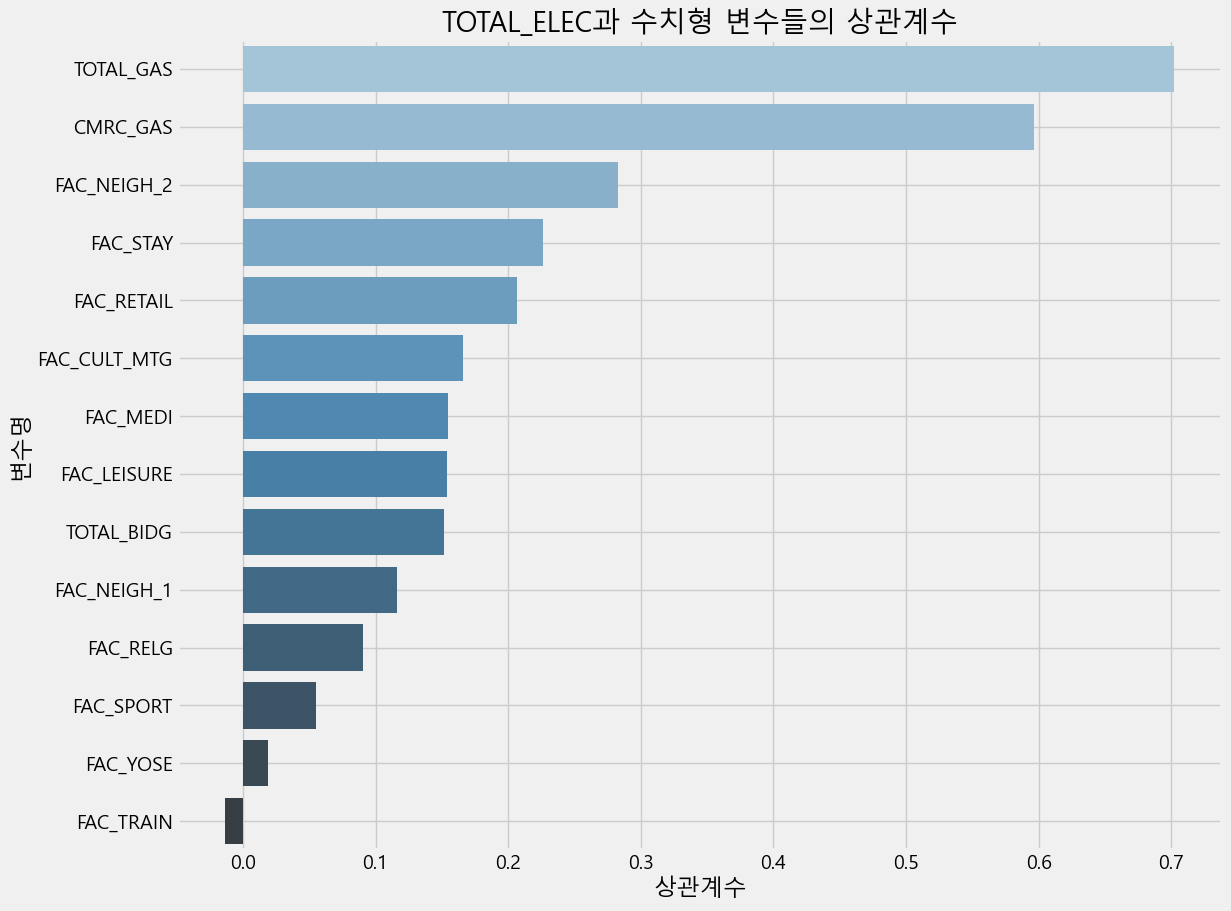

In [8]:
# 수치형 컬럼만 필터링 (float64나 int64)
numeric_cols = train_data.select_dtypes(include=["float64", "int64"]).columns

# 타겟과의 상관계수 계산
correlation = train_data[numeric_cols].corr()["TOTAL_ELEC"].drop("TOTAL_ELEC").sort_values(ascending=False)

# 상관계수 출력
print("📌 TOTAL_ELEC과 상관 높은 변수 순위:\n")
print(correlation)

# 시각화 (막대그래프)
plt.figure(figsize=(12, 10)) 
sns.barplot(x=correlation.values, y=correlation.index, palette="Blues_d")
plt.title("TOTAL_ELEC과 수치형 변수들의 상관계수")
plt.xlabel("상관계수")
plt.ylabel("변수명")
plt.grid(True)

1. 수치형 변수 vs 타겟 상관관계 해석<br>TOTAL_GAS, CMRC_GAS는 TOTAL_ELEC와 각각 0.7, 0.65 수준의 높은 양의 상관 → 매우 중요한 피처<br>그 외 FAC_NEIGH_2, FAC_STAY, FAC_RETAIL 등은 0.2~0.3 사이 → 보조 피처로 유의미

2. 해석:<br>
➡ 전기 사용량이 많은 상권일수록 가스 사용량도 많고, 상업 시설도 많음<br>
➡ 연료 수요와 편의시설이 전력 수요와 직결됨

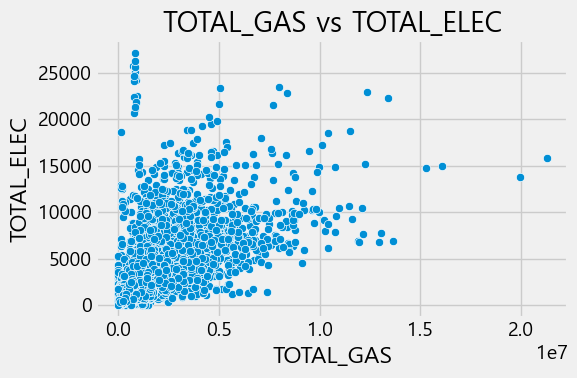

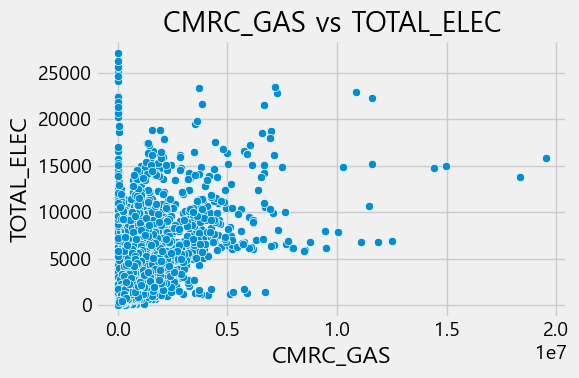

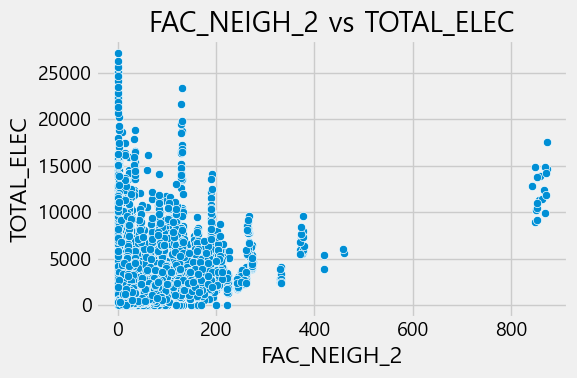

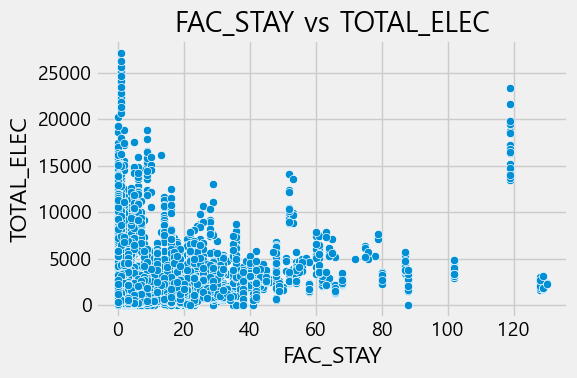

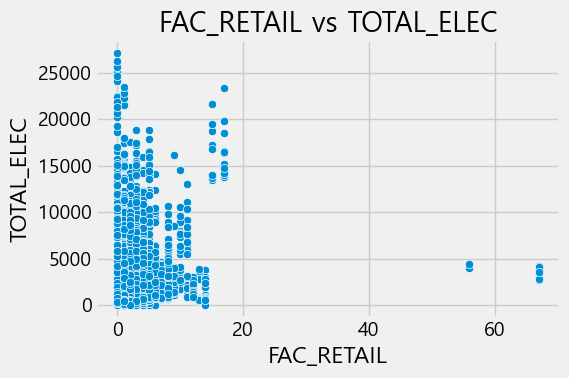

In [9]:
# 상관계수 기준 상위 5개 변수 가져오기
top_corr_features = correlation.head(5).index.tolist()

# 산점도 그리기 및 저장
for feature in top_corr_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train_data, x=feature, y="TOTAL_ELEC")
    plt.title(f"{feature} vs TOTAL_ELEC")
    plt.xlabel(feature)
    plt.ylabel("TOTAL_ELEC")
    plt.grid(True)
    plt.tight_layout()

3. 산점도 분석 (상위 5 변수)

TOTAL_GAS, CMRC_GAS는 점들이 뭉치면서 우상향, 비선형성도 조금 있음 → XGBoost 같은 트리 모델 적합

FAC_NEIGH_2나 FAC_STAY 등은 일정 범위 넘으면 급증하는 경향 → 로그 스케일로 변환해보면 좋음

### 범주형 변수 (그래프)

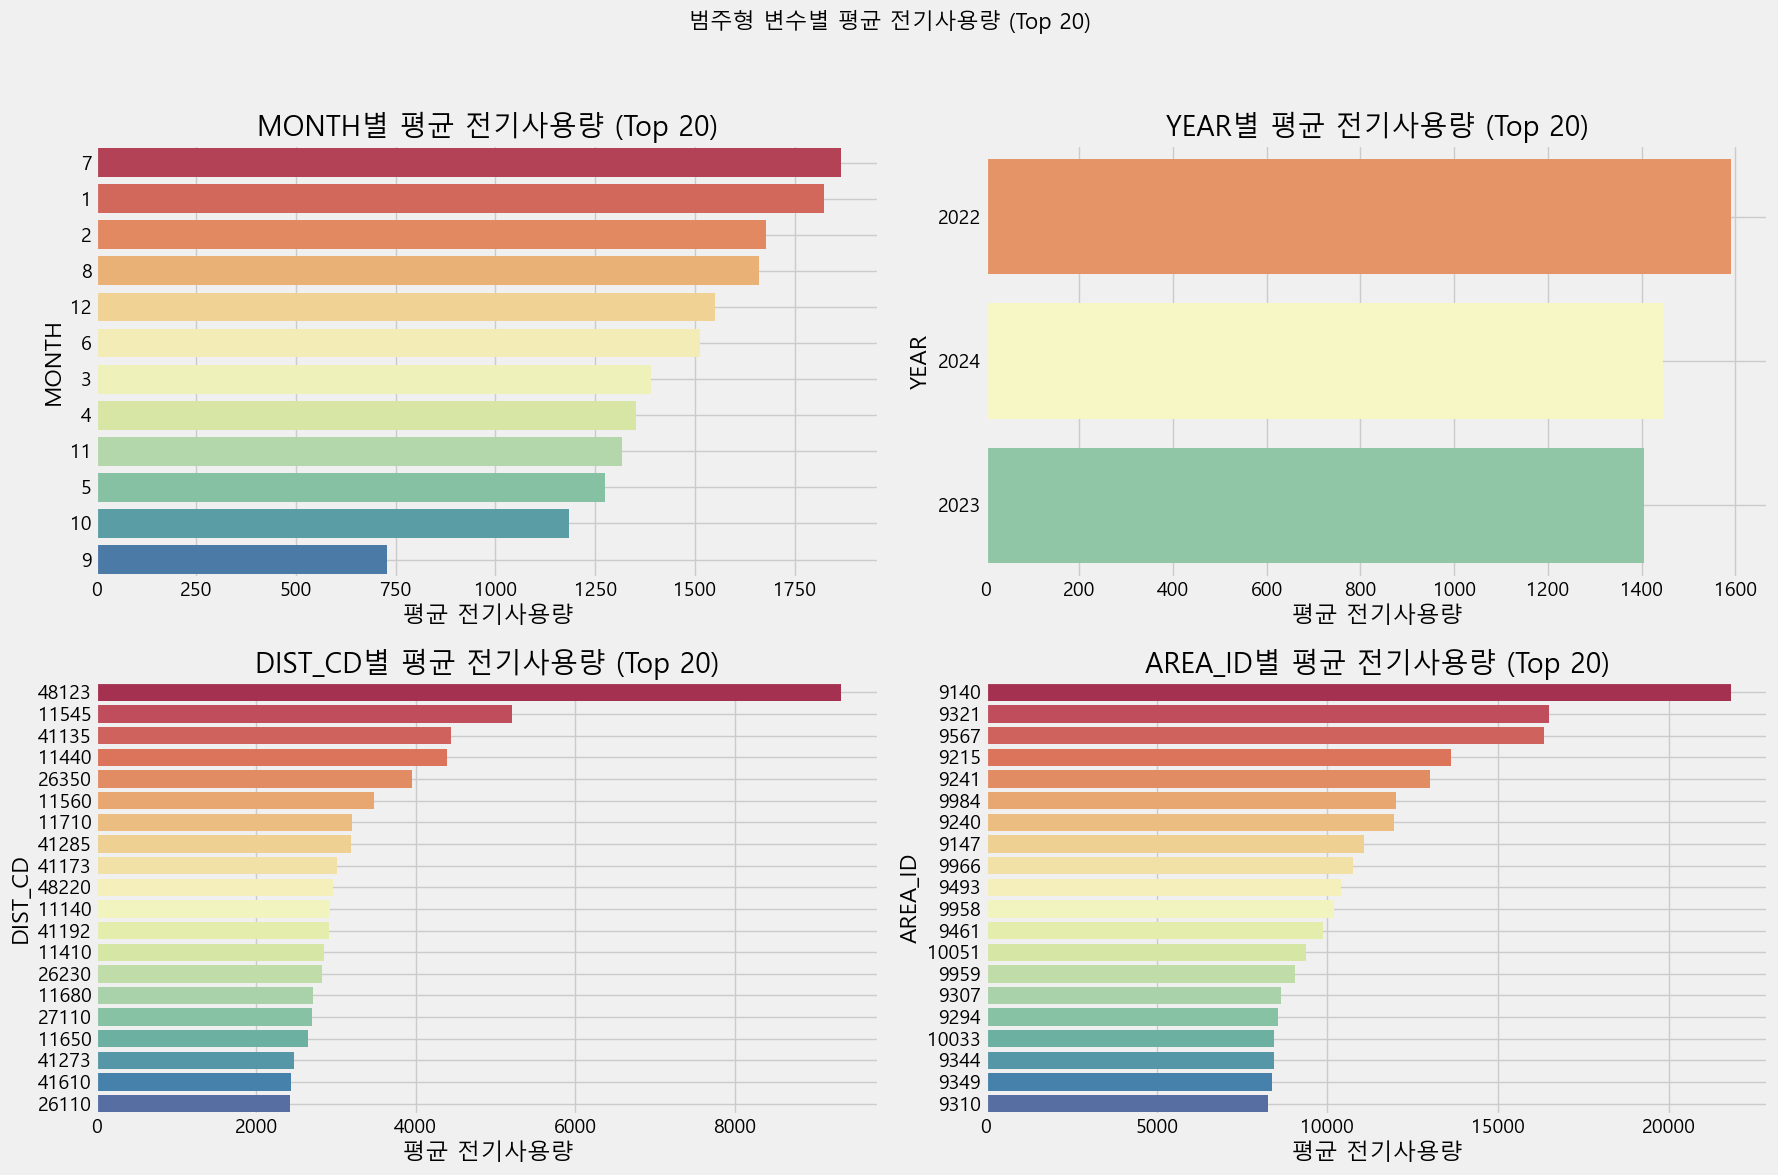

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화할 범주형 변수 리스트
cat_vars = ["MONTH", "YEAR", "DIST_CD", "AREA_ID"]

# 2x2 subplot 구성
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("범주형 변수별 평균 전기사용량 (Top 20)", fontsize=16)

# 반복문으로 Top 20 막대그래프
for i, var in enumerate(cat_vars):
    row = i // 2
    col = i % 2

    # groupby 평균 상위 20개
    grouped = train_data.groupby(var)["TOTAL_ELEC"].mean().sort_values(ascending=False).head(20)

    sns.barplot(x=grouped.values, y=grouped.index.astype(str), ax=axes[row][col], palette="Spectral")
    axes[row][col].set_title(f"{var}별 평균 전기사용량 (Top 20)")
    axes[row][col].set_xlabel("평균 전기사용량")
    axes[row][col].set_ylabel(var)
    axes[row][col].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# 이미지 저장은 show() 전에 해야 함!
plt.savefig("범주형_변수별_평균_전기사용량.jpg", dpi=300, bbox_inches='tight')  # 한글은 파일명에 _ 쓰는 게 안전해

plt.show()

4.  범주형 변수의 분포 해석 (Boxplot)<br>
MONTH, YEAR는 전기 사용량의 차이가 거의 없음<br>
➡ seasonality (계절성)가 약하다고 볼 수 있음

5. DIST_CD, AREA_ID는 큰 편차와 이상치가 많음<br>
➡ 상권/지역 고유 특성이 큼 → one-hot encoding or target encoding

6. 범주형 변수의 평균 전기 사용량 (Top 20)<br>
일부 DIST_CD, AREA_ID는 평균 전기 사용량이 엄청 높음<br>
➡ 해당 지역이나 상권 특성이 모델 예측력에 큰 영향 줄 수 있음<br>
➡ 범주형 변수 중 일부는 예측에 있어 핵심 힌트일 수 있음

***

## 데이터 시각화 후 인사이트 도출

🛠️ 향후 모델 성능 개선을 위한 제안 (RMSE 낮추기)<br><br>
✔️ 1. 파생 변수 생성<br>
|  파생 변수	                              |         설명         |
|-----------------------------------------| --------------------|
|GAS_PER_BLDG = TOTAL_GAS / TOTAL_BIDG	| 건물당 평균 가스 사용량|
|ELEC_PER_BLDG = TOTAL_ELEC / TOTAL_BIDG | 건물당 평균 전기 사용량|
|CMRC_GAS_RATIO = CMRC_GAS / TOTAL_GAS | 상업용 가스 비율|
➡ 스케일 보정 + 시설 효율성 측정용 파생변수로 성능 향상 가능성 있음

✔️ 2. 변수 변환<br>
FAC_NEIGH_2, FAC_STAY, TOTAL_GAS 등 → log 변환 (np.log1p) 시 분포 안정화 가능<br>
정규화보단 **트리 모델(XGBoost)**에서 변환 효과 큼

✔️ 3. 범주형 변수 처리<br>
    AREA_ID, DIST_CD 등 → 수가 많아서 원-핫보다 타겟 인코딩이 효과적일 수 있음
        <br>(단, KFold 타겟 인코딩으로 리크 방지 필수)
    <br>MONTH는 sin/cos 변환해서 seasonality 약간 반영해도 무방

✔️ 4. 모델링 전략
|모델|이유|
|----|---|
|XGBoost         |	비선형 관계 처리, 이상치 강건함|
|LightGBM	       | 범주형 변수 자동 처리 지원|
|CatBoost	      | 범주형 변수 많은 경우 최적|
➡ 교차검증(k-fold)과 함께 진행하면 RMSE 안정화 가능
<br><br>


RMSE를 더 낮추려면:<br><br>

1. 파생 변수 생성

2. 비선형 분포 변수 log 변환

3. 범주형 변수 인코딩 전략 고도화

4. 모델 튜닝 (GridSearch or Optuna)